# **Step 1: Download the Chest X-Ray Pneumonia Dataset from Kaggle**
We use the kagglehub library to directly download the Chest X-Ray Images (Pneumonia) dataset from Kaggle. This dataset contains labeled lung X-ray images categorized into:

**NORMAL — Healthy lungs**

**PNEUMONIA — Lungs with pneumonia (can be bacterial or viral)**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import os

# Check folder contents
os.listdir(path)

['chest_xray']

After downloading the dataset, we check the contents of the dataset folder to confirm that the files and directories have been extracted correctly.

The dataset typically contains the following subfolders:

*   train/ — Training images
*   val/ — Validation images
*   test/ — Test images

Each of these contains two folders: NORMAL/ and PNEUMONIA/


In [3]:
from pathlib import Path
import os

# Actual dataset folder
dataset_path = Path(path) / "chest_xray"

# See what's inside
os.listdir(dataset_path)


['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [4]:
# Just to verify one example folder
import os

# Use the dataset_path variable to access the train, val, and test directories
print("train/ contains:", os.listdir(dataset_path / "train"))
print("val/ contains:", os.listdir(dataset_path / "val"))
print("test/ contains:", os.listdir(dataset_path / "test"))

train/ contains: ['PNEUMONIA', 'NORMAL']
val/ contains: ['PNEUMONIA', 'NORMAL']
test/ contains: ['PNEUMONIA', 'NORMAL']


# **Step 2: Combine Train, Test, and Validation Sets into One Folder**
To simplify model training, we combine all the images from the train, test, and val folders into a single dataset directory named chest_xray_combined. This makes it easier to relabel, balance, or split the data ourselves later using FastAI tools.

Key points:

*   We merge all images of each class (NORMAL,
PNEUMONIA) into their respective folders under chest_xray_combined/.
*   This is useful when we want to relabel pneumonia cases as BACTERIAL or VIRAL in later steps.



In [5]:
from pathlib import Path
import shutil
import os # Import os to ensure os.listdir is available if needed elsewhere

# Unified dataset folder
combined_path = Path("/content/chest_xray_combined")
combined_path.mkdir(parents=True, exist_ok=True)

# Copy data from all three folders
for split in ['train', 'test', 'val']:
    for label in ['NORMAL', 'PNEUMONIA']:
        # Construct the source path using the dataset_path
        src = dataset_path / split / label
        dst = combined_path / label
        dst.mkdir(parents=True, exist_ok=True)
        # Ensure the source directory exists before trying to iterate
        if src.exists() and src.is_dir():
            for file in src.iterdir():
                shutil.copy(file, dst / file.name)
        else:
            print(f"Warning: Source directory does not exist: {src}")

# **Step 3: Create DataLoaders with FastAI**
We use FastAI’s ImageDataLoaders.from_folder() method to automatically load images from the combined dataset and prepare them for training.

**Key configurations:**

* **valid_pct=0.2**: 20% of the data is reserved for validation.

*   **Resize(460):** Images are resized initially to 460 pixels on the longest side for uniformity.

*   **aug_transforms(size=224)**: Applies standard image augmentations like flipping, rotation, zooming, etc., and resizes the images to 224×224 pixels.

*  **bs=32**: Sets the batch size to 32 images.






We also visualize a few samples using dls.show_batch() to confirm the data loading and augmentation are working as expected.

In [7]:
from fastai.vision.all import *

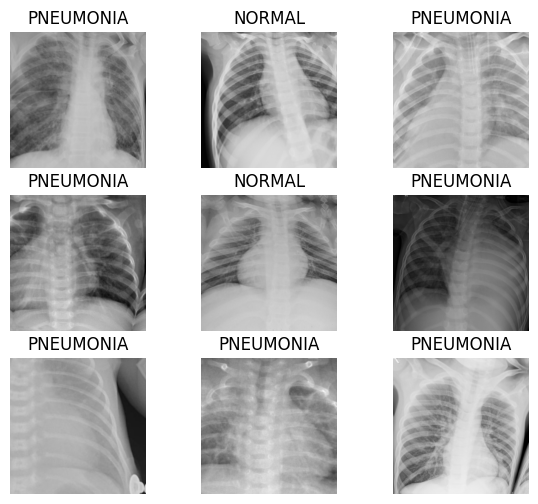

In [8]:
dls = ImageDataLoaders.from_folder(
    combined_path,
    valid_pct=0.2,     # 80% training, 20% validation
    seed=42,           # For reproducibility
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224),
    bs=32
)


dls.show_batch(max_n=9, figsize=(7,6))


# **Step 4: Build and Train the Pneumonia Classification Model**
We now build a convolutional neural network using FastAI’s vision_learner with a ResNet50 backbone. This model will classify chest X-ray images into two categories:


* NORMAL   
* PNEUMONIA




In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(12)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.485560,0.441290,0.895816,02:16


epoch,train_loss,valid_loss,accuracy,time
0,0.280236,0.247127,0.935952,02:23
1,0.198082,0.249894,0.922289,02:17
2,0.185051,0.193884,0.940222,02:25
3,0.148138,0.156807,0.961571,02:20
4,0.124250,0.132317,0.961571,02:21
5,0.124768,0.116052,0.959009,02:19
6,0.097157,0.112288,0.970965,02:18
7,0.108281,0.107616,0.963279,02:20


epoch,train_loss,valid_loss,accuracy,time
0,0.280236,0.247127,0.935952,02:23
1,0.198082,0.249894,0.922289,02:17
2,0.185051,0.193884,0.940222,02:25
3,0.148138,0.156807,0.961571,02:20
4,0.124250,0.132317,0.961571,02:21
5,0.124768,0.116052,0.959009,02:19
6,0.097157,0.112288,0.970965,02:18
7,0.108281,0.107616,0.963279,02:20
8,0.067001,0.109566,0.964133,02:19
9,0.065498,0.099957,0.967549,02:18


Saved the trained model in "pneumonia_3class_model"

In [ ]:
learn.save("pneumonia_3class_model")

Path('/content/chest_xray_combined/models/pneumonia_3class_model.pth')

 This ensures your model is safely reloaded even after runtime restarts in Colab.

In [ ]:
import torch
from torch.serialization import safe_globals
import numpy

# Recreate the learner architecture first
learn = vision_learner(dls, resnet50, metrics=accuracy)

# Load weights safely
with safe_globals(["numpy._core.multiarray.scalar"]):
    learn.load("pneumonia_3class_model", with_opt=True, weights_only=False)

# **Step 5: Evaluate Model Performance — Confusion Matrix & Top Losses**
After training the model, it’s important to analyze its performance. FastAI provides the ClassificationInterpretation class to help visualize and understand where the model performs well — and where it struggles.

✅ What We’re Doing:

*   **plot_confusion_matrix():** Shows how often the model confuses one class for another (e.g., viral vs bacterial).
*  **plot_top_losses():** Displays the images where the model made the largest prediction errors (i.e., was most "confidently wrong").

These visual tools are essential in medical imaging tasks to verify the reliability of the model.



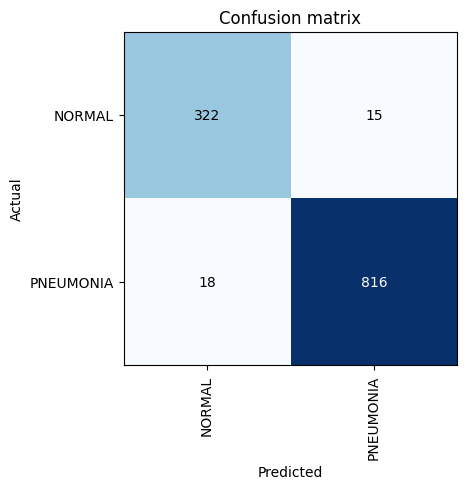

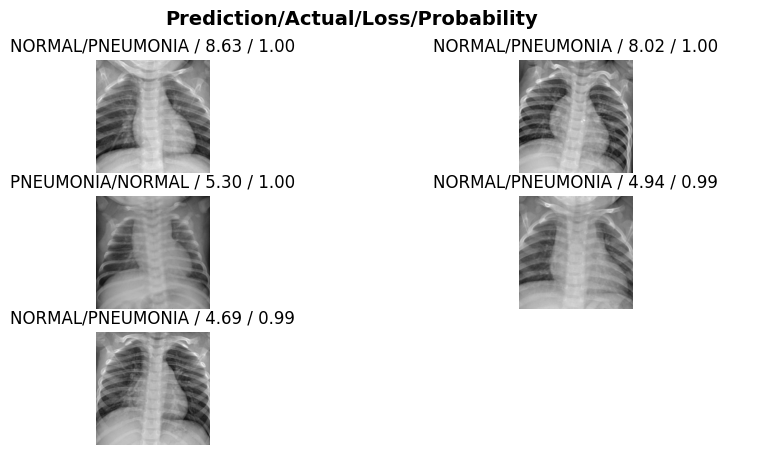

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=3,figsize=(10,5))

###  Confusion Matrix Observations

####  Key Takeaways:

1. **High Overall Accuracy**:
   - Out of 1,171 total predictions (322 + 15 + 18 + 816), the model made **1,138 correct predictions**.
   - That results in an overall **accuracy of ~97.18%**.

2. **Normal Class Performance**:
   - **322/337 normal X-rays** were correctly classified as normal.
   - Only **15 normal X-rays** were misclassified as pneumonia.
   - This shows a **false positive rate** (Normal → Pneumonia) of ~4.45%.

3. **Pneumonia Class Performance**:
   - **816/834 pneumonia cases** were correctly identified.
   - **18 pneumonia cases** were misclassified as normal.
   - This means the **false negative rate** (Pneumonia → Normal) is ~2.16%, which is medically critical.

4. **Medical Implication**:
   - The model tends to slightly **over-diagnose pneumonia**, which is preferable to missing cases.
   - However, the **18 false negatives** (missed pneumonia cases) highlight the importance of further improvements.

####  Overall:
The model performs **very well**, especially considering the subtle differences in chest X-ray images. However, in clinical practice, even small error rates must be minimized, particularly for serious conditions like pneumonia.


# **Step 6: Make a Prediction on a Sample X-ray Image**

*   The model correctly classified the image as NORMAL with 100% confidence.

*   The X-ray is displayed below the output with the predicted label as the title.

Prediction: NORMAL, Probability: 1.0000


<Axes: title={'center': 'Prediction: NORMAL'}>

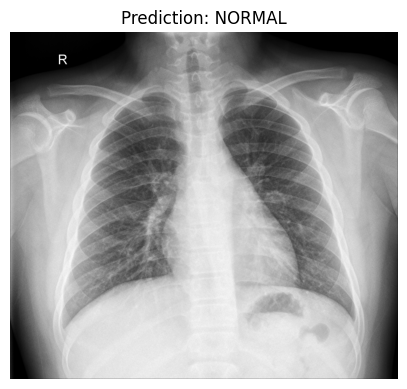

In [ ]:
img = PILImage.create(combined_path/'NORMAL'/os.listdir(combined_path/'NORMAL')[0])
pred_class, pred_idx, probs = learn.predict(img)

print(f"Prediction: {pred_class}, Probability: {probs[pred_idx]:.4f}")
img.show(title=f"Prediction: {pred_class}")


Saved the model in "pneumonia_model_fastai.pkl"

In [ ]:
learn.export('pneumonia_model_fastai.pkl')

# **Step 7: Preparing to Classify Between Bacterial and Viral Pneumonia**

Now that we've successfully built a pneumonia detection model, let's **extend it further** by distinguishing between the two types of pneumonia:

- **Bacterial Pneumonia**
- **Viral Pneumonia**

In the original dataset under `train/PNEUMONIA`, the filenames contain labels that help us split them:

These filenames contain either:

"bacteria" → for Bacterial Pneumonia

"virus" → for Viral Pneumonia

We’ll now use this information to relabel the pneumonia images into two separate categories, so our model can learn to classify between bacterial vs viral pneumonia cases specifically.

In [ ]:
import os

# Use the path variable to access the train directory
pneumonia_files = os.listdir(os.path.join(path, "chest_xray", "train", "PNEUMONIA"))
print(pneumonia_files[:10])

['person1180_virus_2010.jpeg', 'person1230_virus_2081.jpeg', 'person1513_virus_2632.jpeg', 'person124_virus_238.jpeg', 'person746_virus_1369.jpeg', 'person588_bacteria_2422.jpeg', 'person466_virus_960.jpeg', 'person1590_bacteria_4175.jpeg', 'person399_bacteria_1805.jpeg', 'person59_bacteria_279.jpeg']


# **Step 8: Create a 3-Class Dataset — Normal, Bacterial, and Viral**

Now that we've seen pneumonia cases contain both **bacterial** and **viral** types, we’re ready to extend our classification model to handle **three categories**:

- **NORMAL**
- **BACTERIAL_PNEUMONIA**
- **VIRAL_PNEUMONIA**

We'll create a new folder structure that splits pneumonia images based on their filenames (which contain either `'bacteria'` or `'virus'`) and combine data from all splits (`train`, `test`, `val`) into unified class folders.


In [ ]:
from pathlib import Path
import shutil
import os # Import os to ensure os.listdir is available if needed elsewhere

# Define new target folder
combined_3class = Path("/content/chest_xray_3class")
(combined_3class / 'NORMAL').mkdir(parents=True, exist_ok=True)
(combined_3class / 'BACTERIAL_PNEUMONIA').mkdir(parents=True, exist_ok=True)
(combined_3class / 'VIRAL_PNEUMONIA').mkdir(parents=True, exist_ok=True)

# Copy over NORMAL images
for split in ['train', 'test', 'val']:
    # Correctly construct the source path using the base dataset_path
    src = dataset_path / split / 'NORMAL'
    # Ensure the source directory exists before trying to iterate
    if src.exists() and src.is_dir():
        for img in src.iterdir():
            shutil.copy(img, combined_3class / 'NORMAL' / img.name)
    else:
        print(f"Warning: Source directory does not exist: {src}")

# Copy PNEUMONIA images into bacterial or viral
for split in ['train', 'test', 'val']:
    # Correctly construct the source path using the base dataset_path
    src = dataset_path / split / 'PNEUMONIA'
    # Ensure the source directory exists before trying to iterate
    if src.exists() and src.is_dir():
        for img in src.iterdir():
            name = img.name.lower()
            if "bacteria" in name:
                shutil.copy(img, combined_3class / 'BACTERIAL_PNEUMONIA' / img.name)
            elif "virus" in name:
                shutil.copy(img, combined_3class / 'VIRAL_PNEUMONIA' / img.name)
    else:
        print(f"Warning: Source directory does not exist: {src}")

# **Step 9: Load the 3-Class Dataset into FastAI**

With our dataset now structured into three folders — `NORMAL`, `BACTERIAL_PNEUMONIA`, and `VIRAL_PNEUMONIA` — we can use **FastAI's `ImageDataLoaders.from_folder`** to load the images and prepare them for training.


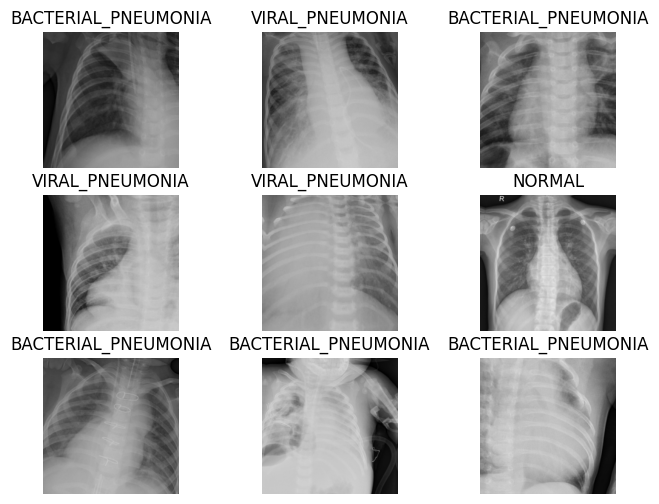

In [ ]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(
    combined_3class,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224),
    bs=32
)

dls.show_batch(max_n=9, figsize=(8,6))


# **Step 13: Train the Model on the 3-Class Pneumonia Dataset**

We now create a **CNN-based classifier** using FastAI’s `vision_learner` with a **ResNet50** backbone, which is pre-trained on ImageNet. This allows for faster and more accurate training through **transfer learning**.

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.095273,0.808761,0.751494,02:11


epoch,train_loss,valid_loss,accuracy,time
0,0.736308,0.580054,0.774552,02:13
1,0.613694,0.514903,0.804441,02:14
2,0.568479,0.481471,0.813834,02:13
3,0.503599,0.448753,0.814688,02:12
4,0.468745,0.447945,0.812980,02:12
5,0.421823,0.436541,0.824082,02:12
6,0.391301,0.422382,0.831768,02:13
7,0.363562,0.425474,0.830914,02:11
8,0.353484,0.430066,0.834330,02:10
9,0.329769,0.423397,0.834330,02:10


Saved the learned model in "pneumonia_4class_model"

In [ ]:
learn.save("pneumonia_4class_model")

Path('/content/chest_xray_3class/models/pneumonia_4class_model.pth')

In [ ]:
from fastai.vision.all import *

Reload the weights  safely

In [ ]:
import torch
from torch.serialization import safe_globals
import numpy

# Recreate the learner architecture first
learn_pneumonia = vision_learner(dls, resnet50, metrics=accuracy)

# Load weights safely
with safe_globals(["numpy._core.multiarray.scalar"]):
    learn_pneumonia.load("pneumonia_4class_model", with_opt=True, weights_only=False)

# **Step 14: Model Evaluation – Confusion Matrix and Top Losses**

We evaluate the performance of the trained model using a confusion matrix and top-loss analysis.

**Key Insights:**



*   The model performs very well on NORMAL and BACTERIAL pneumonia.
*   It struggles with differentiating VIRAL from BACTERIAL, misclassifying 97 viral cases as bacterial.
*   This confusion is understandable as both bacterial and viral pneumonia can show visually similar patterns in X-rays.




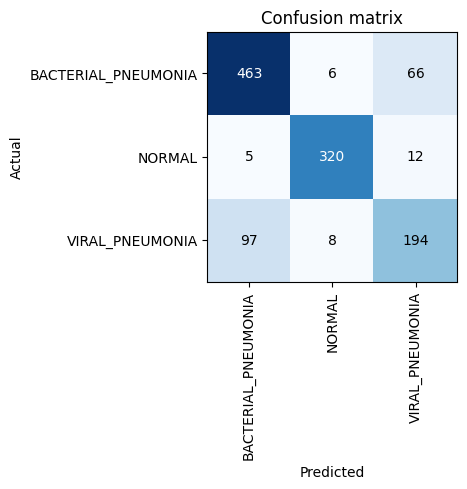

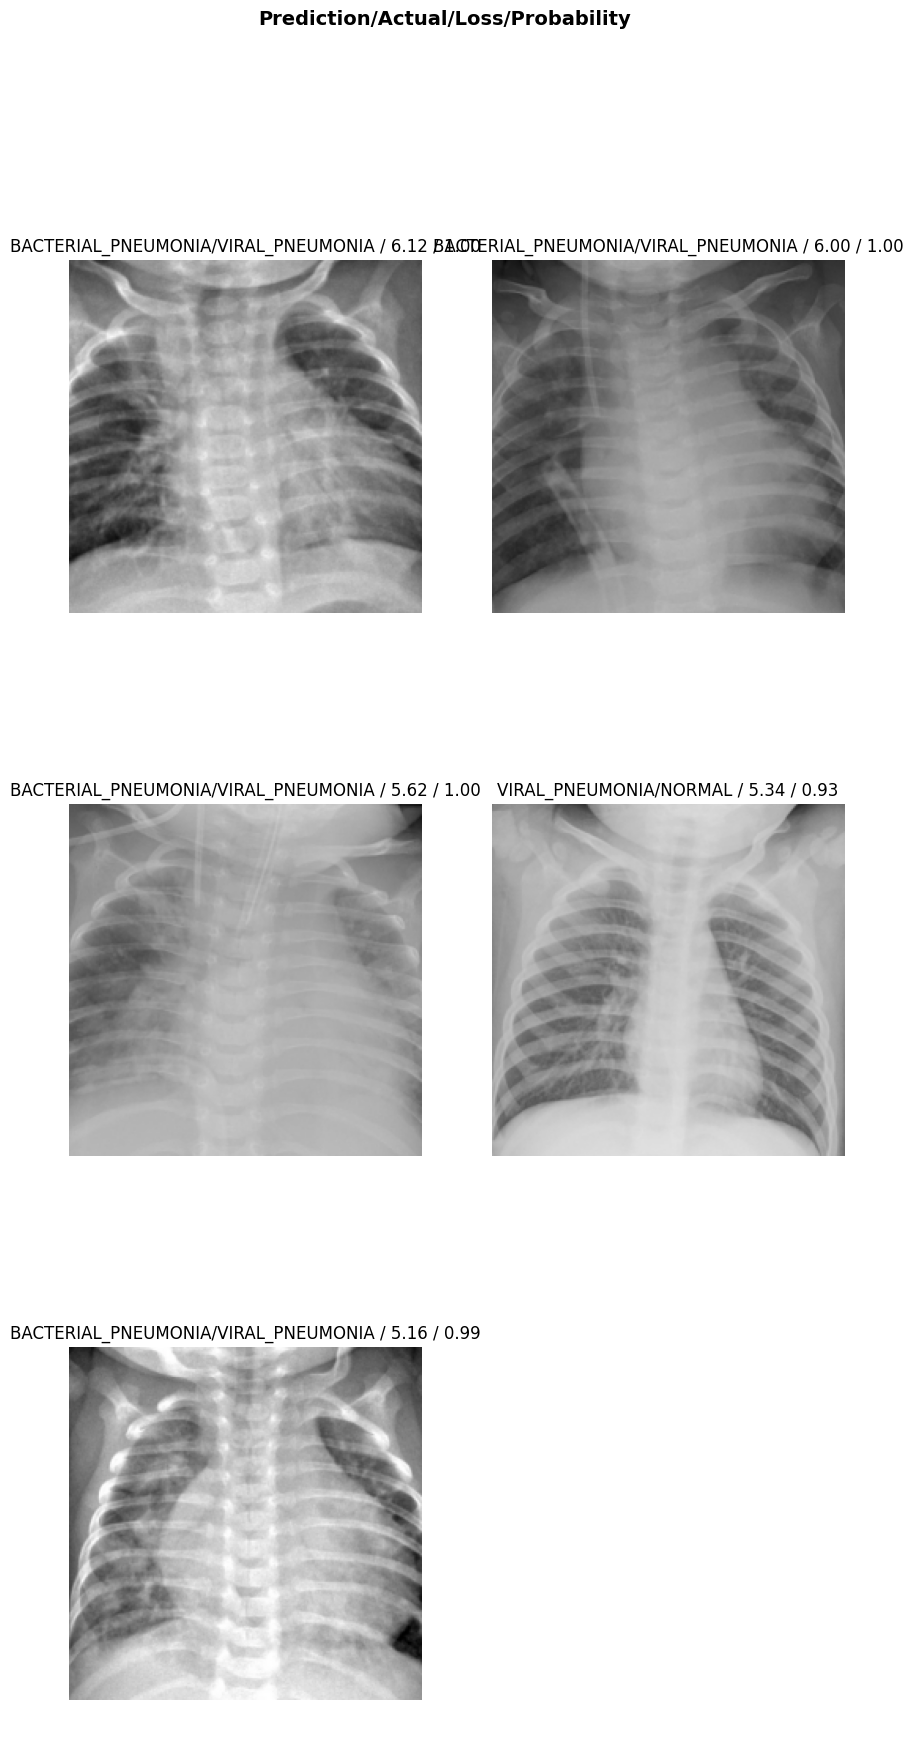

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=3,figsize=(10,20))

In [ ]:
learn.export('pneumonia_4class_model.pkl')

# **Step 15: Predicting on a New Chest X-ray Image**

We now test our trained model by predicting the class of a **new, unseen X-ray image**.


🔍 Predicted Class: VIRAL_PNEUMONIA
📊 Class Probabilities:
  BACTERIAL_PNEUMONIA: 0.1248
  NORMAL: 0.0012
  VIRAL_PNEUMONIA: 0.8740


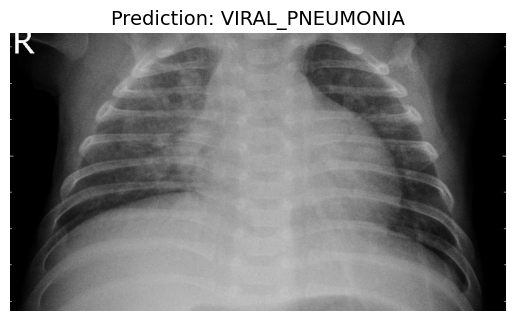

In [ ]:
# Predict from a new image
img_path = Path('/content/chest_xray_3class/VIRAL_PNEUMONIA/person1004_virus_1686.jpeg')

# Show prediction
print(f"🔍 Predicted Class: {pred_class}")
print(f"📊 Class Probabilities:")
for cls, prob in zip(learn.dls.vocab, probs):
    print(f"  {cls}: {prob:.4f}")

import matplotlib.pyplot as plt
from PIL import Image

# Display image
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Prediction: {pred_class}", fontsize=14)
plt.show()

**Interpretation:**

*   The model is highly confident (87.4%) that the image represents Viral Pneumonia.
*   
It assigns a very low probability to Normal class, and a moderate confusion with Bacterial Pneumonia, which is expected due to visual similarity in lung infection patterns.